# Hawkes Process Causal Discovery Example\n\nThis notebook demonstrates causal network discovery using the **Hawkes Process** information method with self-exciting point processes.\n\n## Overview\n- Generate synthetic time series with known causal structure\n- Visualize the dynamics and network structure\n- Apply causal discovery using Hawkes Process conditional mutual information\n- Evaluate performance using ROC-AUC metric\n\n

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve
import warnings
warnings.filterwarnings('ignore')

# Import causal discovery components
from causalentropy.core.discovery import discover_network
from causalentropy.datasets.synthetic import hawkes_coupled_processes

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette('inferno')
print('Libraries imported successfully!')

Libraries imported successfully!


## 1. Create Ground Truth Network\n\nWe'll create a directed graph that represents the true causal relationships.

In [2]:
# Create a ground truth network
n_nodes = 5
seed = 42
p = 0.2 

# Create a specific network structure
np.random.seed(seed)
G_true = nx.erdos_renyi_graph(n_nodes, p, seed=seed, directed=True)

print(f"Ground truth network has {G_true.number_of_nodes()} nodes and {G_true.number_of_edges()} edges")
print(f"Edges: {list(G_true.edges())}")

# Get adjacency matrix for later comparison
A_true = nx.to_numpy_array(G_true)
print(f"\nGround truth adjacency matrix:")
print(A_true)

Ground truth network has 5 nodes and 6 edges
Edges: [(0, 2), (1, 4), (2, 1), (3, 0), (3, 1), (4, 3)]

Ground truth adjacency matrix:
[[0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [1. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]]


## 2. Generate Synthetic Hawkes Process Data\n\nGenerate self-exciting point processes with the known causal structure.

In [3]:
# Generate synthetic Hawkes Process data
T = 200  # Time series length

# Generate data using hawkes_coupled_processes
data, A_generated = hawkes_coupled_processes(
    n=n_nodes,
    T=T,
    G=G_true,
    mu_base=0.5,
    alpha=0.3,
    beta=1.0,
    coupling_strength=0.2,
    dt=0.1,
    seed=seed)
print(f'Generated Hawkes Process data with shape: {data.shape}')
print(f'Data statistics:')
print(f'Mean: {np.mean(data):.3f}')
print(f'Std:  {np.std(data):.3f}')
print(f'Range: [{np.min(data):.3f}, {np.max(data):.3f}]')
print(f'Data type: Binary event indicators')

Generated Hawkes Process data with shape: (200, 5)
Data statistics:
Mean: 0.089
Std:  0.285
Range: [0.000, 1.000]
Data type: Binary event indicators


## 3. Visualize Time Series Data\n\nPlot the self-exciting point processes to understand the data characteristics.

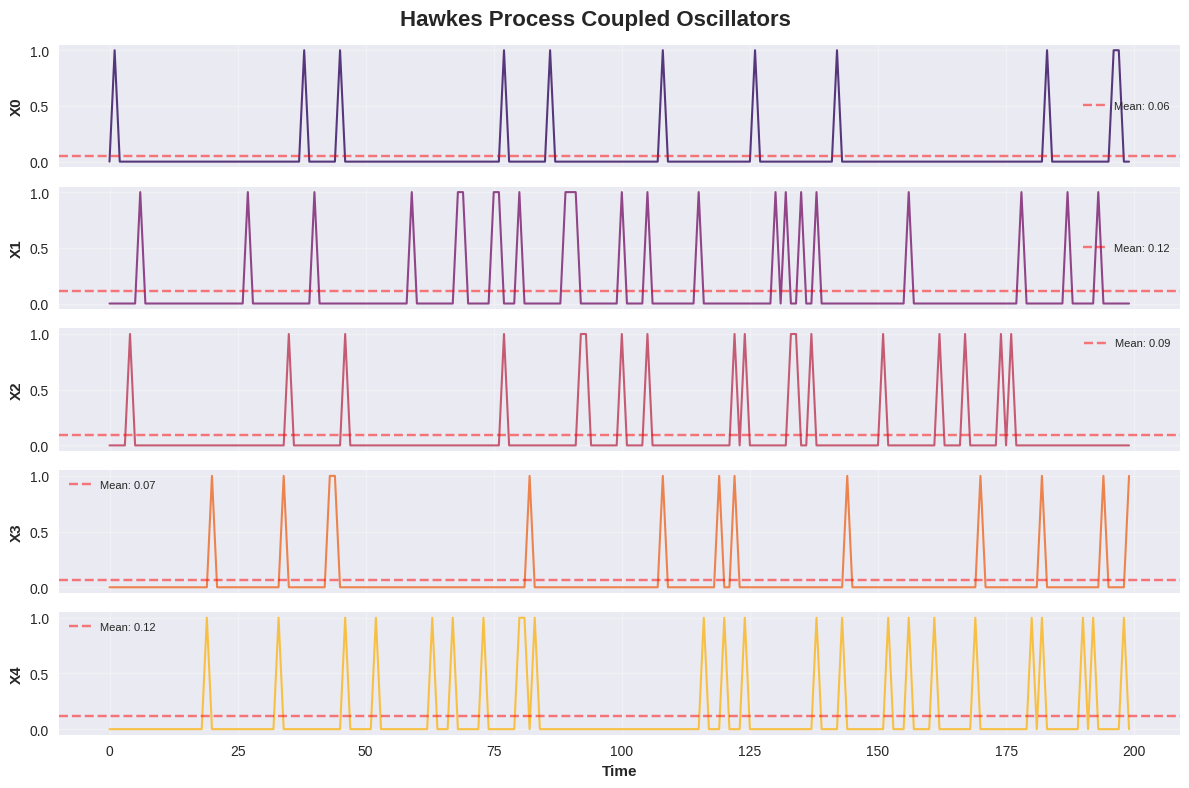

In [4]:
# Plot time series
fig, axes = plt.subplots(n_nodes, 1, figsize=(12, 8), sharex=True)
fig.suptitle('Hawkes Process Coupled Oscillators', fontsize=16, fontweight='bold')
time = np.arange(T)
colors = sns.color_palette('inferno', n_nodes)
for i in range(n_nodes):
    axes[i].plot(time, data[:, i], color=colors[i], alpha=0.8, linewidth=1.5)
    axes[i].set_ylabel(f'X{i}', fontweight='bold')
    axes[i].grid(True, alpha=0.3)
    mean_val = np.mean(data[:, i])
    axes[i].axhline(mean_val, color='red', linestyle='--', alpha=0.5,
                    label=f'Mean: {mean_val:.2f}')
    axes[i].legend(fontsize=8)
    
axes[-1].set_xlabel('Time', fontweight='bold')
plt.tight_layout()
plt.show()

## 4. Visualize Ground Truth Network

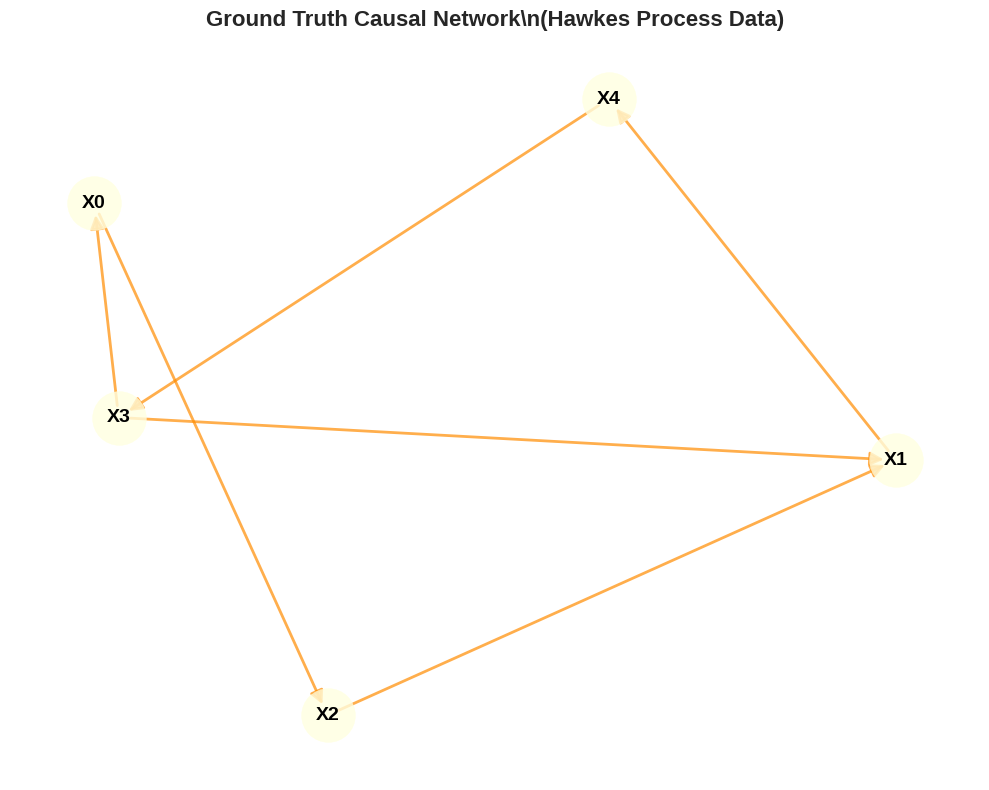

In [5]:
# Plot ground truth network
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G_true, seed=seed, k=2, iterations=50)
nx.draw_networkx_nodes(G_true, pos, node_color='lightyellow',
                       node_size=1500, alpha=0.8)
nx.draw_networkx_edges(G_true, pos, edge_color='darkorange',
                       arrows=True, arrowsize=20, width=2, alpha=0.7)
nx.draw_networkx_labels(G_true, pos, {i: f'X{i}' for i in range(n_nodes)},
                        font_size=14, font_weight='bold')
plt.title('Ground Truth Causal Network\\n(Hawkes Process Data)',
          fontsize=16, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()

## 5. Apply Causal Discovery

Use the Hawkes Process method to discover causal relationships.

In [15]:
timestamps_data[1].shape

(23,)

In [13]:
print("Applying causal discovery with Hawkes Process information method...")
print("This may take a few moments...\n")

dt = 0.1  # time step used during simulation
timestamps_data = []
for i in range(data.shape[1]):
    timestamps = np.where(data[:, i] == 1)[0] * dt
    timestamps_data.append(timestamps)

#timestamps_data = np.asarray(timestamps_data)

methods_to_test = ['standard', 'alternative']
discovered_networks = {}

for method in methods_to_test:
    print(f"Running {method} method...")

    G_discovered = discover_network(
        data=timestamps_data,
        method=method,
        information='hawkes',
        max_lag=2,
        alpha_forward=0.05,
        alpha_backward=0.05,
        n_shuffles=100
    )

    discovered_networks[method] = G_discovered
    print(f"  Discovered {G_discovered.number_of_edges()} edges")
    print(f"  Edges: {list(G_discovered.edges())}")

Applying causal discovery with Hawkes Process information method...
This may take a few moments...

Running standard method...


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (5,) + inhomogeneous part.

In [ ]:
# Plot comparison of networks
fig, axes = plt.subplots(1, len(methods_to_test) + 1, figsize=(5 * (len(methods_to_test) + 1), 5))
if len(methods_to_test) == 1:
    axes = [axes[0], axes[1]]

# Plot ground truth
ax = axes[0]
nx.draw_networkx_nodes(G_true, pos, node_color='lightgreen', 
                       node_size=1000, alpha=0.8, ax=ax)
nx.draw_networkx_edges(G_true, pos, edge_color='darkgreen', 
                       arrows=True, arrowsize=15, width=2, alpha=0.7, ax=ax)
nx.draw_networkx_labels(G_true, pos, {i: f'X{i}' for i in range(n_nodes)},
                        font_size=10, font_weight='bold', ax=ax)
ax.set_title('Ground Truth', fontweight='bold')
ax.axis('off')

# Plot discovered networks
colors = ['lightcoral', 'lightsalmon', 'lightsteelblue']
edge_colors = ['darkred', 'red', 'darkblue']

for i, (method, G_disc) in enumerate(discovered_networks.items()):
    ax = axes[i + 1]
    
    # Convert node names back to integers for consistent positioning
    G_disc_int = nx.DiGraph()
    G_disc_int.add_nodes_from(range(n_nodes))
    for edge in G_disc.edges():
        src = int(edge[0].replace('X', '')) if 'X' in str(edge[0]) else int(edge[0])
        dst = int(edge[1].replace('X', '')) if 'X' in str(edge[1]) else int(edge[1])
        G_disc_int.add_edge(src, dst)
    
    nx.draw_networkx_nodes(G_disc_int, pos, node_color=colors[i], 
                           node_size=1000, alpha=0.8, ax=ax)
    nx.draw_networkx_edges(G_disc_int, pos, edge_color=edge_colors[i], 
                           arrows=True, arrowsize=15, width=2, alpha=0.7, ax=ax)
    nx.draw_networkx_labels(G_disc_int, pos, {i: f'X{i}' for i in range(n_nodes)},
                            font_size=10, font_weight='bold', ax=ax)
    ax.set_title(f'Discovered ({method})', fontweight='bold')
    ax.axis('off')

plt.suptitle('Network Comparison: Gaussian Method', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## 6. Calculate ROC-AUC Performance

In [ ]:
def calculate_roc_auc(true_adj, discovered_graph):\n    \"\"\"Calculate ROC-AUC for network discovery performance.\"\"\"\n    n = true_adj.shape[0]\n    \n    G_int = nx.DiGraph()\n    G_int.add_nodes_from(range(n))\n    for edge in discovered_graph.edges():\n        src = int(edge[0].replace('X', '')) if 'X' in str(edge[0]) else int(edge[0])\n        dst = int(edge[1].replace('X', '')) if 'X' in str(edge[1]) else int(edge[1])\n        G_int.add_edge(src, dst)\n    \n    discovered_adj = nx.adjacency_matrix(G_int, nodelist=range(n)).toarray()\n    \n    mask = ~np.eye(n, dtype=bool).flatten()\n    y_true = true_adj.flatten()[mask]\n    y_scores = discovered_adj.flatten()[mask]\n    \n    if len(np.unique(y_true)) > 1:\n        auc_score = roc_auc_score(y_true, y_scores)\n        fpr, tpr, _ = roc_curve(y_true, y_scores)\n        return auc_score, fpr, tpr\n    else:\n        return None, None, None\n\n# Calculate ROC-AUC\nresults = {}\nplt.figure(figsize=(10, 6))\n\nfor method, G_disc in discovered_networks.items():\n    auc_score, fpr, tpr = calculate_roc_auc(A_true, G_disc)\n    \n    if auc_score is not None:\n        results[method] = {'auc': auc_score, 'fpr': fpr, 'tpr': tpr}\n        plt.plot(fpr, tpr, linewidth=2, label=f'{method} (AUC = {auc_score:.3f})')\n        print(f'{method} method: ROC-AUC = {auc_score:.3f}')\n\nplt.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random (AUC = 0.500)')\nplt.xlabel('False Positive Rate', fontweight='bold')\nplt.ylabel('True Positive Rate', fontweight='bold')\nplt.title('ROC Curves for Hawkes Process Causal Discovery', fontweight='bold')\nplt.legend()\nplt.grid(True, alpha=0.3)\nplt.tight_layout()\nplt.show()

## 7. Conclusions

In [ ]:
print('\\n' + '='*60)\nprint('EXPERIMENT CONCLUSIONS - HAWKES PROCESS CAUSAL DISCOVERY')\nprint('='*60)\n\nprint(f'📊 DATA CHARACTERISTICS:')\nprint(f'  • Data type: Binary event indicators')\nprint(f'  • Time series length: {T}')\nprint(f'  • Number of variables: {n_nodes}')\nprint(f'  • Ground truth edges: {G_true.number_of_edges()}')\n\nprint(f'🔍 DISCOVERY RESULTS:')\nbest_auc = 0\nbest_method = None\nfor method, G_disc in discovered_networks.items():\n    auc_val = results.get(method, {}).get('auc', 0)\n    print(f'  • {method.capitalize()}: {G_disc.number_of_edges()} edges, AUC = {auc_val:.3f}')\n    if auc_val > best_auc:\n        best_auc = auc_val\n        best_method = method\n\nif best_method:\n    print(f'🏆 BEST METHOD: {best_method.upper()}')\n    print(f'  • ROC-AUC: {best_auc:.3f}')\n\nprint(f'💡 HAWKES PROCESS METHOD INSIGHTS:')\nprint(f'  • Designed for self-exciting point processes')\nprint(f'  • Data type: Binary event indicators')\nprint(f'  • Performance depends on data characteristics and coupling strength')\n\nprint('Experiment completed! 🎉')